<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_2_Bias_Variance_Trade_Off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bias-Variance Trade-Off**

This notebook investigates the bias-variance trade-off for a toy model and reproduces bias/variance trade off curves.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [3]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y


In [4]:
# Draw the fitted function, together with uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

/var/folders/yk/83x2smm96b9_trlwmwsyv1g00000gn/T/ipykernel_46989/1040896329.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/yk/83x2smm96b9_trlwmwsyv1g00000gn/T/ipykernel_46989/1040896329.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


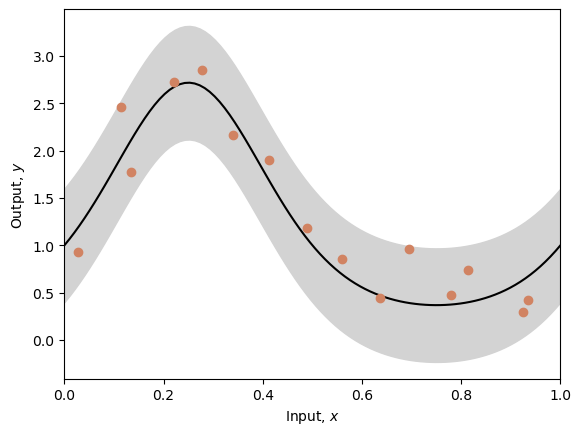

In [5]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the functinon, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [6]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [7]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega


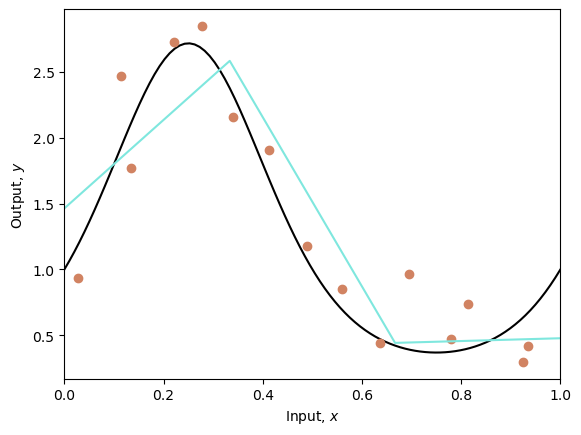

In [8]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

In [9]:
import numpy as np

def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):
    # Assumes x_model is a global variable of shape (n_model_points,)
    global x_model

    # Create array to store model outputs
    y_model_all = np.zeros((n_datasets, x_model.shape[0]))

    for c_dataset in range(n_datasets):
        # 1. Generate input data uniformly in [-1, 1]
        x_data = np.random.uniform(-1, 1, n_data).reshape(-1, 1)

        # 2. Generate noisy output data using a true function plus noise
        noise = np.random.normal(0, sigma_func(x_data), size=(n_data, 1))
        y_data = np.sin(np.pi * x_data) + noise  # Example true function

        # 3. Sample fixed random weights for hidden layer (Random Fourier Features style)
        omega = np.random.normal(0, 1, size=(n_hidden, 1))
        b = np.random.uniform(0, 2*np.pi, size=(n_hidden, 1))

        # 4. Compute hidden layer features
        Z_data = np.sqrt(2 / n_hidden) * np.cos(x_data @ omega.T + b.T)

        # 5. Fit linear weights beta by ridge regression (lambda = 1e-3)
        lambda_ridge = 1e-3
        beta = np.linalg.solve(Z_data.T @ Z_data + lambda_ridge * np.eye(n_hidden), Z_data.T @ y_data)

        # 6. Compute model predictions for x_model
        Z_model = np.sqrt(2 / n_hidden) * np.cos(x_model.reshape(-1,1) @ omega.T + b.T)
        y_model = Z_model @ beta  # Shape: (len(x_model), 1)

        # Store model results
        y_model_all[c_dataset, :] = y_model.ravel()

    # Mean and standard deviation across datasets
    mean_model = np.mean(y_model_all, axis=0)
    std_model = np.std(y_model_all, axis=0)

    return mean_model, std_model


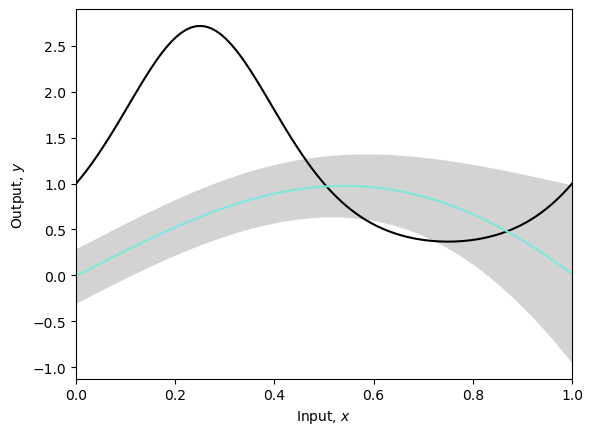

In [20]:
# Let's generate N random data sets, fit the model N times and look the mean and variance
n_datasets = 100
n_data = 16
sigma_func = lambda x: 0.3
n_hidden = 50

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func) ;

# Plot the results
plot_function(x_func, y_func, x_model=x_model, y_model=mean_model, sigma_model=std_model)

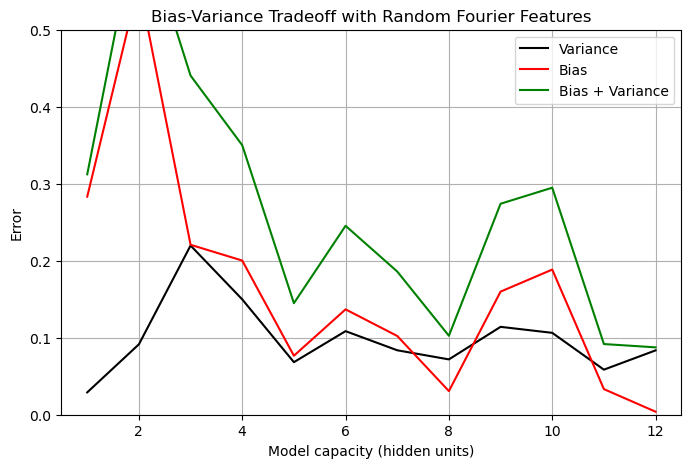

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true function
def true_function(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)

# Feature mapping using Random Fourier Features
def compute_phi(x, omega, b):
    return np.sqrt(2 / omega.shape[0]) * np.cos(np.dot(x, omega.T) + b)

# Fit model and return predictions
def fit_rff_model(x_data, y_data, x_eval, omega, b, lam=1e-4):
    phi_data = compute_phi(x_data, omega, b)
    phi_eval = compute_phi(x_eval, omega, b)
    
    # Ridge regression (regularized least squares)
    I = np.eye(phi_data.shape[1])
    w = np.linalg.solve(phi_data.T @ phi_data + lam * I, phi_data.T @ y_data)
    
    return phi_eval @ w

# Function to get bias, variance for a model capacity (n_hidden)
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_noise, x_func):
    d = 1  # input dimension
    omega = np.random.normal(0, 1, (n_hidden, d))  # fixed Fourier basis
    b = np.random.uniform(0, 2 * np.pi, size=(n_hidden,))
    
    y_models = np.zeros((len(x_func), n_datasets))

    for i in range(n_datasets):
        x_data = np.random.uniform(0, 1, (n_data, 1))
        y_true_data = true_function(x_data)
        noise = np.random.normal(0, sigma_noise, size=(n_data, 1))
        y_data = y_true_data + noise
        
        y_pred = fit_rff_model(x_data, y_data, x_func, omega, b)
        y_models[:, i] = y_pred.flatten()

    mean_model = np.mean(y_models, axis=1)
    variance_model = np.var(y_models, axis=1)
    
    return mean_model, variance_model, y_models

# Parameters
n_data = 15
n_datasets = 100
sigma_noise = 0.3
hidden_variables = list(range(1, 13))
x_func = np.linspace(0, 1, 100).reshape(-1, 1)
y_true = true_function(x_func)

# Store bias and variance
bias = np.zeros(len(hidden_variables))
variance = np.zeros(len(hidden_variables))

# Fix seed for reproducibility
np.random.seed(1)

# Run experiment
for i, n_hidden in enumerate(hidden_variables):
    mean_model, var_model, y_models = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_noise, x_func)

    # Bias: squared difference between mean prediction and true function
    bias[i] = np.mean((mean_model - y_true.flatten()) ** 2)

    # Variance: average variance of predictions
    variance[i] = np.mean(var_model)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(hidden_variables, variance, 'k-', label='Variance')
plt.plot(hidden_variables, bias, 'r-', label='Bias')
plt.plot(hidden_variables, variance + bias, 'g-', label='Bias + Variance')
plt.xlabel("Model capacity (hidden units)")
plt.ylabel("Error")
plt.ylim(0, 0.5)
plt.xlim(0.5, 12.5)
plt.legend()
plt.title("Bias-Variance Tradeoff with Random Fourier Features")
plt.grid(True)
plt.show()
